In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# For reproducibility
np.random.seed(42)


In [9]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def generate_eeg_signal(fs, duration, attention_type):
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)

    if attention_type == "Divided":
        freqs = np.random.uniform(8, 12, size=10)  # Alpha band
    elif attention_type == "Selective":
        freqs = np.random.uniform(4, 8, size=10)  # Theta band
    elif attention_type == "Executive":
        freqs = np.random.uniform(12, 30, size=10)  # Beta band
    elif attention_type == "Sustained":
        freqs = np.random.uniform(1, 4, size=10)   # Delta band
    else:
        freqs = np.random.uniform(1, 30, size=10)  # Broad spectrum for any other state

    # Generate the signal by combining sinusoids of these frequencies
    signal = np.sum([np.sin(2 * np.pi * f * t) for f in freqs], axis=0)

    # Add noise to simulate real EEG
    noise = np.random.normal(0, 0.5, signal.shape)
    signal += noise

    # Bandpass filter the signal to mimic real EEG
    signal = butter_bandpass_filter(signal, 1, 40, fs)

    return signal


In [10]:
fs = 256  # Sampling frequency in Hz
duration = 5  # Duration of each sample in seconds

n_samples = 100  # Number of samples per attention state

attention_states = ['Divided', 'Selective', 'Executive', 'Sustained']
eeg_data = []
labels = []

for state in attention_states:
    for _ in range(n_samples):
        signal = generate_eeg_signal(fs, duration, state)
        eeg_data.append(signal)
        labels.append(state)

# Convert to DataFrame
eeg_df = pd.DataFrame(eeg_data)
eeg_df['label'] = labels

print(eeg_df.head())

eeg_df.to_csv('synthetic_eeg_attention_data.csv', index=False)


          0         1         2         3         4         5         6  \
0 -0.001733  0.008224  0.134749  0.628423  1.736851  3.421955  5.255974   
1  0.000302  0.020590  0.172814  0.717345  1.915168  3.720640  5.673836   
2  0.001374  0.028581  0.193860  0.734111  1.884925  3.627128  5.547401   
3  0.001180  0.031016  0.214611  0.795322  1.961171  3.593666  5.253716   
4 -0.003209 -0.004141  0.090481  0.552380  1.714292  3.600277  5.688587   

          7         8         9  ...      1271      1272      1273      1274  \
0  6.638078  7.166785  6.849598  ... -3.437050 -3.521105 -3.651920 -3.659820   
1  7.154125  7.745185  7.396376  ... -2.028337 -2.720792 -3.184582 -3.416964   
2  7.006980  7.540030  7.132172  ...  1.249466  1.587420  2.020129  2.513011   
3  6.457356  6.949169  6.761827  ... -2.734388 -2.711211 -2.375865 -1.877924   
4  7.192012  7.624424  7.063049  ... -2.098234 -1.721844 -1.308728 -0.930799   

       1275      1276      1277      1278      1279    label  
0 -3.

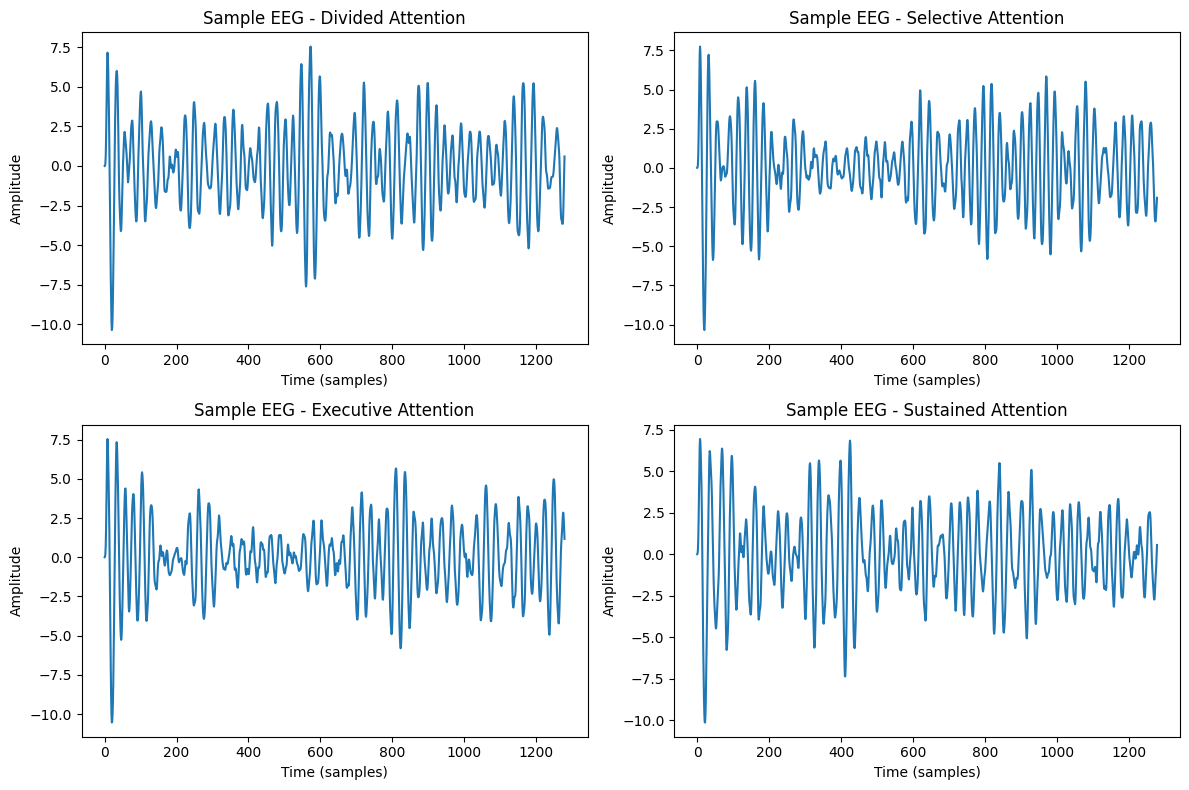

In [11]:
# Visualize sample signals
plt.figure(figsize=(12, 8))

for i, state in enumerate(attention_states):
    plt.subplot(2, 2, i+1)
    plt.plot(eeg_df.iloc[i, :-1])
    plt.title(f'Sample EEG - {state} Attention')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

eeg_df = pd.read_csv('synthetic_eeg_attention_data.csv')

X = eeg_df.iloc[:, :-1].values
y = eeg_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [14]:
from scipy.fft import fft

def calculate_bandpower(eeg_signal, fs=256):
    freqs = np.fft.fftfreq(len(eeg_signal), 1/fs)
    fft_values = np.abs(fft(eeg_signal))**2

    delta_band = (1, 4)
    theta_band = (4, 8)
    alpha_band = (8, 12)
    beta_band = (12, 30)

    def bandpower(freq_range):
        idx_band = np.where((freqs >= freq_range[0]) & (freqs <= freq_range[1]))[0]
        return np.sum(fft_values[idx_band])

    return [
        bandpower(delta_band),
        bandpower(theta_band),
        bandpower(alpha_band),
        bandpower(beta_band)
    ]

def extract_features(eeg_data, fs=256):
    feature_data = []
    for sample in eeg_data:
        bandpowers = calculate_bandpower(sample, fs)
        feature_data.append(bandpowers)
    return np.array(feature_data)

X_train_features = extract_features(X_train_scaled)
X_test_features = extract_features(X_test_scaled)



In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train_features, y_train)

y_pred = clf.predict(X_test_features)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Classification Report:\n", classification_report(y_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

     Divided       1.00      1.00      1.00        20
   Executive       1.00      1.00      1.00        20
   Selective       1.00      1.00      1.00        20
   Sustained       1.00      1.00      1.00        20

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

Confusion Matrix:
 [[20  0  0  0]
 [ 0 20  0  0]
 [ 0  0 20  0]
 [ 0  0  0 20]]


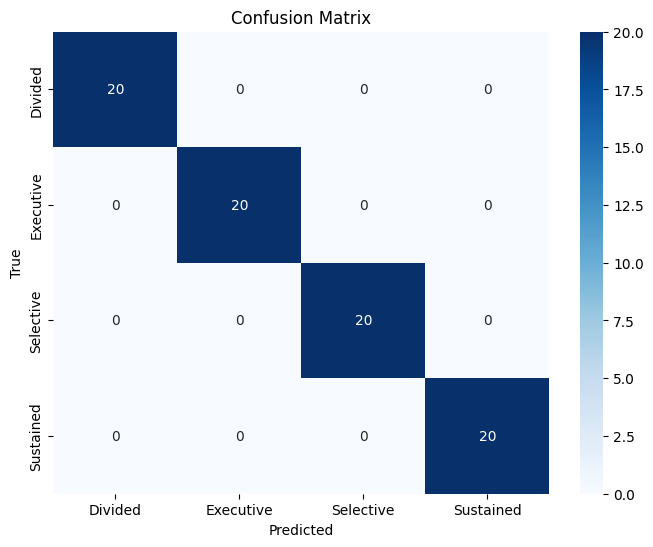

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [18]:
import pickle


In [19]:
with open('eeg_attention_classifier.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)


In [20]:
with open('eeg_attention_classifier.pkl', 'rb') as model_file:
    loaded_clf = pickle.load(model_file)

y_pred_loaded = loaded_clf.predict(X_test_features)

print(f"Accuracy of the loaded model: {accuracy_score(y_test, y_pred_loaded) * 100:.2f}%")


Accuracy of the loaded model: 100.00%


In [22]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(loaded_clf, X_train_features, y_train, cv=5)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Average Cross-Validation Score: {np.mean(cv_scores)}")


Cross-Validation Scores: [1. 1. 1. 1. 1.]
Average Cross-Validation Score: 1.0
